***РОЗПІЗНАВАННЯ ОБЛИЧ ЗА ДОПОМОГОЮ ЗГОРТКОВИХ НЕЙРОННИХ МЕРЕЖ***

In [1]:
import os
import numpy as np
import datetime
import pandas as pd
import time
import tensorflow as tf
from itertools import product
from keras import backend as K
from tensorflow.python.client import device_lib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array, to_categorical
from keras.models import Sequential
from keras.applications import inception_v3, resnet, vgg16
from keras.models import Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Dropout, BatchNormalization, AveragePooling2D
from keras.activations import relu, selu
from tensorflow_addons.activations import mish
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

In [ ]:
# завантаження бібліотек
# pip install tensorflow
# pip install keras
# pip install keras_tuner
# pip install tensorflow_addons

Навчання глибоких нейронних мереж потребує затратних по часу і ресурсам
обчислювальних операцій, тому я підключаюся до локальної середи виконання, використовую Compute Unified Device Architecture (CUDA). Це паралельна обчислювальна платформа, розроблена NVIDIA що дозволяє програмному забезпеченню спільно використовувати центральний і графічний процесори.

Запускаю скрипт в Anaconda Powershell Prompt і отриманий лінк прописую в середовищі google colab:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6598931087666010735
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2247832372
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18573245947328416
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

Функції, які в подальшому використовуватимемо.

In [4]:
def load_data(path, img_size=256):
    """
      Завантаження даних-картинок, на виході отримаємо два нормалізованих numpy-масива
    """
    imgs, labels = [], []
    for i in os.listdir(path):
        folder_path = os.path.join(path, i)
        for image in os.listdir(folder_path):
            img_path = os.path.join(folder_path, image)
            img = load_img(img_path, target_size=(img_size, img_size))
            x = img_to_array(img)
            imgs.append(x / 255.0)
            labels.append(i)
    return np.array(imgs), np.array(labels)


#тестова вибірка з призначеними мітками
def show_images(images, labels):
    plt.figure(figsize=(10, 6))
    
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        if labels[i] == 0:
            plt.title('jolie')
        else:
            plt.title('other')
        
    plt.axis('off')
    plt.suptitle('PREDICTED LABELS')
    plt.show()

def reset_graph(seed = 42):
  tf.compat.v1.reset_default_graph()
  tf.compat.v1.set_random_seed(seed)
  np.random.seed(seed)


def visualize_learning(fit_history):
  '''
  Графiки змiни значень функцiї втрат та змiни показника accuracy
  '''
  history = fit_history.history

  fig = plt.figure(figsize=(16, 4))
  ax = fig.add_subplot(1, 3, 1)
  plt.plot(history['loss'], lw=4, color="green")
  plt.plot(history['val_loss'], lw=4, color="yellow")
  plt.legend(['Train loss', 'Validation loss'], fontsize=15)
  ax.set_xlabel('Epochs', size=15)

  ax = fig.add_subplot(1, 3, 2)
  plt.plot(history['accuracy'], lw=4, color="green")
  plt.plot(history['val_accuracy'], lw=4, color="yellow")
  plt.legend(['Train accuracy', 'Validation accuracy'], fontsize=15)
  ax.set_xlabel('Epochs', size=15)

  plt.show()

Папка з даними лежить на локальній машині, шлях до неї прописано в змінну my_path. Завантажуємо і оброблюємо дані. Маємо дві вибірки: перша - 70 зображень з американською акторкою Енн Гетевей, друга - 70 зображень, з яких 60 - портрети голівудських зірок і 10 зображень без облич.

In [5]:
my_path = "D:\\datascience\\stars_dataset"
X, y = load_data(my_path)

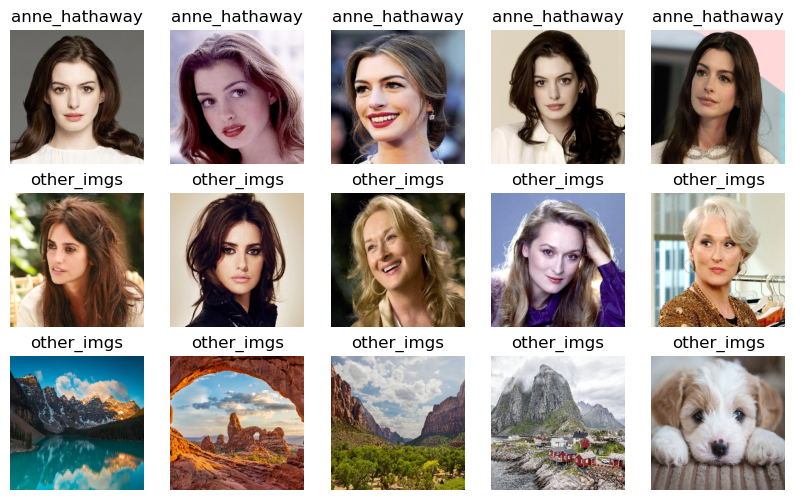

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.axis('off')
    plt.subplot(3, 5, i + 1)
    if i < 5:
        plt.imshow(X[i])
        plt.title(y[i])
    elif i >=5 and i < 10:
        plt.imshow(X[i+90])
        plt.title(y[i+90])
    else:
        plt.imshow(X[i+116])
        plt.title(y[i+116])
plt.axis('off')
plt.show()

Використовуємо кодувальник, який потрібний для задання цільових міток для бінарної класифікації. Розбиваємо вибірку усіх зображень у співвідношенні 70:15:15 на тренувальну, тестову і валідаційну, використовуємо параметр stratify для того, щоб співвідношення міток було однакове - це важливо, коли датасет невеликий за розміром.

In [6]:
encoder = LabelEncoder()
encoder.fit(y)
Y = encoder.transform(y)

In [7]:
X_train, X_t, y_train, y_t = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size=0.5, stratify=y_t)

print(f'Розбиття вибірки: {X_train.shape[0]} train, {X_test.shape[0]} test, {X_val.shape[0]} validation')
print(f'Розмір зображення: {X_train.shape[1:]}')

Розбиття вибірки: 98 train, 21 test, 21 validation
Розмір зображення: (256, 256, 3)


Розмір картинки є глобальною змінною, використовуватимемо її надалі.

In [6]:
img_size = X_train.shape[1:]
print(f'Розмір зображення: {img_size}')

Розмір зображення: (256, 256, 3)


# Налаштування гіперпараметрів

Проведемо експерименти в різних конфігураціях гіперпараметрів та оберемо найкращу. Параметри:

*   Кількість шарів: min=2, max=6, step=1
*   Наявність та параметри dropout: min=0, max=0.5, step=0.1
*   Вид функції активації - relu, lrelu, selu, mish

In [8]:
def CNN_model(n_layers=2, activation='relu', batchNormalization=0, dropout=0):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, kernel_initializer='he_uniform', padding='same', input_shape=X_train.shape[1:]))
    if batchNormalization:
        model.add(BatchNormalization())
    # model.add(MaxPooling2D(2, 2))
    if dropout:
        model.add(Dropout(dropout))

    for i in range(n_layers - 1):
        model.add(Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
        if batchNormalization:
            model.add(BatchNormalization())
        # model.add(MaxPooling2D(2, 2))

    if dropout:
        model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer='l2'))
    model.add(Dense(1, activation='softmax'))  
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [13]:
def CNN_model(n_layers=2, activation='relu', batchNormalization=0, dropout=0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(2, 2))
    if batchNormalization:
        model.add(BatchNormalization())
    for i in range(n_layers - 1):
        model.add(Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D(2, 2))
        if batchNormalization:
            model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation=activation, kernel_initializer='he_uniform'))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax', kernel_regularizer='l2'))  
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
num_layers = [2, 3, 4, 5, 6]
dropout_rate = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
activation = ['relu', 'leaky-relu', 'selu', 'mish']
df_cols = ["Loss", "Acc"]

df_values = []

In [14]:
num_layers = [3]
dropout_rate = [0]
activation = ['relu']
df_cols = ["Loss", "Acc"]

df_values = []

In [15]:
tf.keras.backend.clear_session()

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [16]:
for d in dropout_rate:
    for n in num_layers:
        for a in activation:
            if a == 'leaky-relu':
                act = LeakyReLU()
            elif a == 'mish':
                act = mish
            else:
                act = a
                
            reset_graph()

            cnn = CNN_model(n_layers=n, dropout=d, activation=act)
            callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')

            start_time = time.time()
            hist = cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8, verbose=0, callbacks=[callback])

            print('\t Number of layers: {0}, dropout rate: {1}, activation function: {2} \t'.format(n, d, a))
            print('Learning time: {0:.2f} seconds'.format(time.time() - start_time))

            eval = cnn.evaluate(X_test, y_test, batch_size=8, verbose=0)
            test_loss, test_acc = round(eval[0], 2), round(eval[1], 2)
            df_values.extend([test_loss, test_acc])
            print(f'Test loss: {test_loss}, test accuracy: {test_acc}')

            if eval[1] >= 0.8:
                cnn.save(f'D:\\datascience\\stars_dataset\\keras_models\\{a}_{n}lrs_{d}drop.ckpt')

ResourceExhaustedError: ignored

In [ ]:
mldx_arrays = [np.concatenate([([i]*len(n_layers)) for i in dropout], axis=0),
               np.array(n_layers*len(dropout))]

col_names = list(product(activation, df_cols))
cols = pd.MultiIndex.from_tuples(product(activation, df_cols))

# creating a multi-index dataframe
# with random data
# df = pd.DataFrame(
#   np.random.randn(len(n_layers)*len(dropout), len(col_names)), index=mldx_arrays,
#   columns=cols)

df = pd.DataFrame(
  np.asarray(df_values).reshape((30, 8)), index=mldx_arrays,
  columns=cols)

df.index.names = ['Dropout', 'Num_layers']
df

relu           leaky-relu                selu  \
                        Loss       Acc       Loss       Acc      Loss   
Dropout Num_layers                                                      
0.0     2           0.056818  0.569509   1.078150  1.098421 -2.005743   
        3          -1.268512 -0.897174   0.620480  0.158961  1.085086   
        4          -0.302923  1.721381   0.435924  0.212039 -2.067266   
        5          -0.959876 -0.310021   0.058021 -0.875565  0.750116   
        6           0.033365  1.264364  -2.321329 -0.122993 -1.616701   
0.1     2           1.438490  0.010068   3.328787 -0.097270 -1.665999   
        3          -0.443283  0.947216  -0.764921  0.790699  0.271632   
        4           0.874501 -1.787744  -0.983221 -0.242007  0.891373   
        5          -0.364194 -0.865135  -0.108862 -0.074307 -0.824769   
        6          -0.025111  0.343839  -1.353161 -0.539004  0.611552   
0.2     2          -1.786243 -0.765033   1.962526  1.235533 -0.415438   
        3           0.640865 -1.228591   0.041804 -0.496956 -0.077683   
        4          -0.438170 -0.378443   0.547789 -0.313983 -0.581501   
        5          -0.961135 -0.236367  -0.929980  1.777345 -1.133172   
        6           0.677248  0.934248  -0.517469  1.410676  0.143801   
0.3     2           0.010771 -0.960956  -1.136277 -0.417188 -0.164532   
        3           1.104453  0.164423  -0.419017 -0.658164  0.388392   
        4          -0.677682  1.092648   0.211956  0.905669  1.138741   
        5           1.575011 -0.396288   0.411766 -0.257751  0.115200   
        6          -0.635487  0.756081  -0.045490 -1.165266 -0.887804   
0.4     2          -0.477049 -1.081476  -1.942956 -0.036151  0.969032   
        3           0.917217 -0.071975  -0.949110  0.788847  1.107390   
        4          -1.317519 -1.343368   1.237011 -0.564369  0.943703   
        5           0.032740  0.577551   0.404437 -0.010139  1.547912   
        6           0.524258 -0.740124   1.203523  1.593451  0.347019   
0.5     2           0.403970 -0.051780   0.645896  0.234354 -0.073381   
        3          -0.392950 -0.778487   1.127370 -0.908750 -1.228368   
        4          -0.276829  0.100218  -0.455211  1.350617  0.492552   
        5           0.596298 -1.642466   0.017421  0.013446 -0.177780   
        6           0.362492  0.802675   0.673971 -0.939412 -0.229226   

                                  mish            
                         Acc      Loss       Acc  
Dropout Num_layers                                
0.0     2           1.234077 -0.824784 -1.017346  
        3          -0.550081 -0.850167 -1.112939  
        4           1.388188 -0.627795  0.507172  
        5           0.524267  0.016435 -0.864770  
        6           0.037824  0.120907 -0.557227  
0.1     2          -0.101976 -0.803030  0.982859  
        3          -0.190398  1.569994  0.592083  
        4          -0.099265 -0.816113  0.312196  
        5          -0.828999 -0.301264 -0.335224  
        6           0.598372 -0.943508  1.277926  
0.2     2           1.190042 -0.991012  0.070581  
        3           0.975483  0.395854  0.162825  
        4          -0.169538  1.209572 -0.555415  
        5          -1.096384 -0.697415  0.459491  
        6           2.075379  1.065753  1.004053  
0.3     2          -1.281726 -0.534211 -0.723781  
        3           0.602958 -0.938867  1.030530  
        4          -0.396604  0.494593 -1.245282  
        5           1.984799  0.193864  0.959818  
        6           0.672122 -0.308553 -0.766886  
0.4     2          -0.936143 -0.442322 -1.056217  
        3          -0.483428 -1.212464  0.427601  
        4           0.893518 -0.928558 -0.303316  
        5          -1.883975 -1.942970 -0.393932  
        6           0.616402  0.204994  0.506081  
0.5     2          -0.377434  2.260869 -0.499457  
        3           1.223885  0.532755  0.740394  
        4          -0.262237 -1.377640 -0.560061  
        5           0.571134 -0.7